# Quora Question Pairs

# Business Problem 

1. Description : 
Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

2. Problem Statement :
     * Identify Which question are asked on Quora are duplicates of questions
     * This could be useful to instantly provide answer to question that have already been asked.
     * We are tasked with predciting whether a pair of quesiton are duplicates or not.


# Useful link.
* Discussion :https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/notebook
* Kaggle Winning Solution : https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
* Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
* Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

# Real World /Business Objective and Constraints
1. The cost of misclassification can be very high.
2. We would want a probability of a pair of question to be duplicates so that we can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretabilty is partial important.

# Machine Learning Problem
## Data 
### *Data overview:*
*  Data will be in a file Train.csv
* Train.csv Contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
* size of train.csv: 60MB
* Number of rows in Train.csv = 404,290

### *Example Data point*

"id","qid1","qid2","question1","question2","is_duplicate"

"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"

"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"

"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"

"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"


# Mapping the real world problem to an ML problem
 ## Type of Machine Learning Problem :
 * It is a binary Classification problem ,for a given pair of question we need to predict if they are duplicates or not
## Performance metrics: 
    * Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

    * Metric(s):
        * log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
        * Binary Confusion Matrix


 

# train and test Construction 
We build train and test by randomly splitting into 70:30 or 80:20 whatever we choose as we have sufficient points to worl out.

# Exploratoty Data Analysis



In [1]:
pip install bs4

In [2]:
pip install distance

In [3]:
pip install plotly

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from subprocess import check_output #Run command with arguments and return its output as a byte string.
%matplotlib inline  
import plotly.offline as py 
py.init_notebook_mode(connected=True) #initiate notebook for offline plot
import plotly.graph_objs as go
import plotly.tools as tls
import os #The OS module in python provides functions for interacting with the operating system.
import gc #Garbage collector .
#Python’s memory allocation and deallocation method is automatic. The user does not have to preallocate or deallocate memory similar to using dynamic memory allocation in languages such as C or C++.
#Python uses two strategies for memory allocation:
        #1.Reference counting      #2.Garbage collection

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

# Reading data and basics stats

In [5]:
df =pd.read_csv('train.csv.zip')
print("Number of data points :",df.shape)

Number of data points : (404290, 6)


In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## We have got minimal number of data fields here , consisting of:
* id: Looks like a simple rodID
* qid{1,2}: The unique Id of each question in the pair
* question{1,2}: The actual textual content of question
* is_duplicate: The label that we are trying to predict -wether the two question are duplicates of each other.

# Distribution of data points among output classes
* Number of duplicates (similiar) and non-duplicates(non-similiar)question.

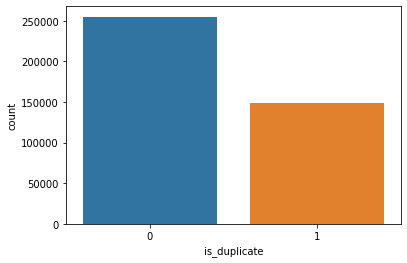

In [8]:
sns.countplot(data=df,x='is_duplicate')

In [9]:
print('~> Total number of question pairs for training:\n {}'.format(len(df)))

~> Total number of question pairs for training:
 404290


In [10]:
#df['is_duplicate'] contains values of 0 and 1 only,
#so if we take a mean of those values that will give the percentage of 1s present.
print("Question pair are not similiar (is_duplicates=0):\n {}%".format(100-round(df['is_duplicate'].mean()*100,2)))
print("Question pair are similiar (is_duplicates=1):\n {}%".format(round(df['is_duplicate'].mean()*100,2)))

Question pair are not similiar (is_duplicates=0):
 63.08%
Question pair are similiar (is_duplicates=1):
 36.92%


In [11]:
# Number of unique Solution
qids=pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs=len(np.unique(qids))
qs_morethan_onetime=np.sum(qids.value_counts()>1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 
q_vals=qids.value_counts()
q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



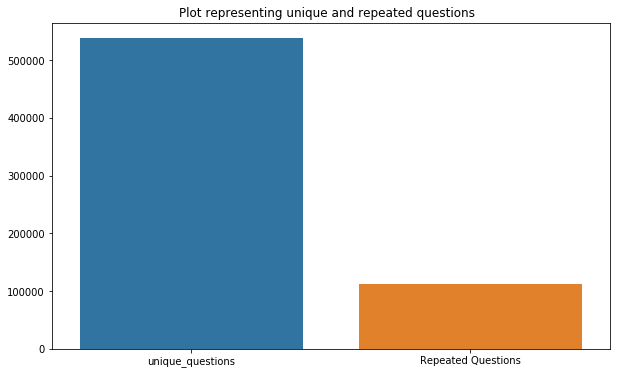

In [12]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]
plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

# Checking for Duplicates

In [13]:
a=[1,2,3,4,5]
b=[3,4,6,7,8]


In [14]:
#Checking whether there are any repeated pair of question.

pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()#
#It groups by q1 and q2 and for each group it gives the count of is_duplicate.

print('Number of duplicats ',pair_duplicates.shape[0]-df.shape[0])

Number of duplicats  0


In [15]:
pair_duplicates=df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

# Number of occurrences of each question

Maximum number of times a single question is repeated : 157 



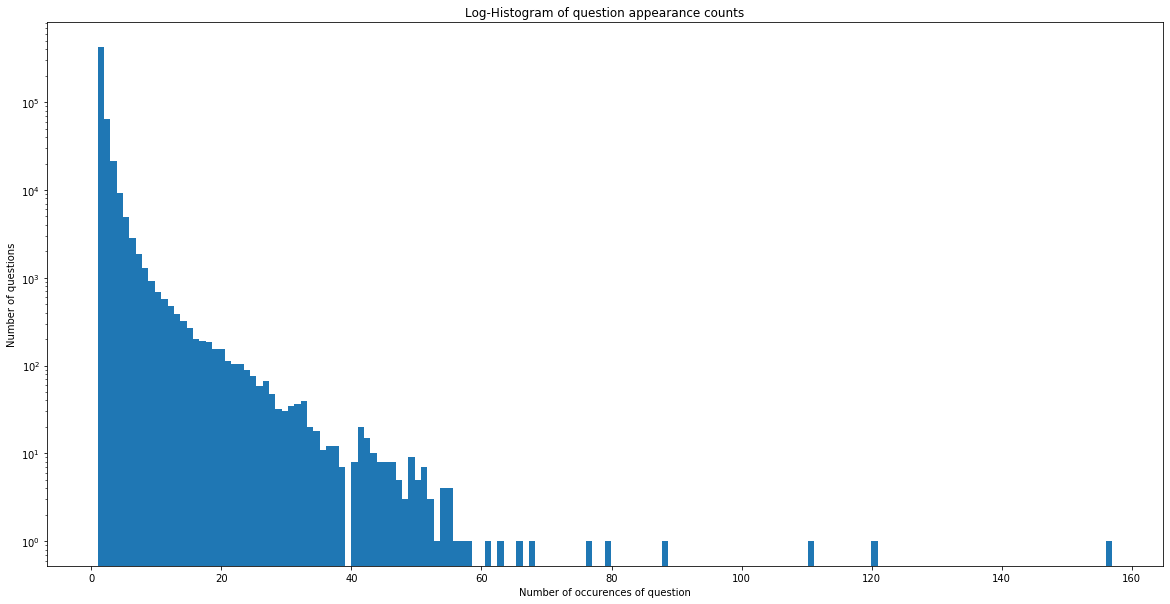

In [16]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale('log',nonposy='clip')
#ply.yscale('log') converts the scale of points to log. Now as log is not defined for negative points ,
#to handle the negative points if any, we are using nonposy and we have two apporaches 1. clip and mask. 
#While mask simply ignores the points, clip will clip negative numbers to smallest positive number 
#so that we don't face issues with negative numbers. nonposy is nothing but non positive number. 
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print('Maximum number of times a single question is repeated : {} \n'.format(max(qids.value_counts())))

# Checking NULL values


In [17]:
# Checking whether there are any rows with null value
nan_rows=df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


* There are two rows with null values in question2 

In [18]:
# Filling the null valus with ' '(space)
df=df.fillna('')
nan_rows=df[df.isnull().any(1)]
print(nan_rows)


Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# BAsic Feature Extraction(before cleaning)

Constucting few features
* freq_qid1= Frequency of qid1's
* freq_qid2= Frequency of qid2's
* q1_len =Length of Question 1
* q2_len =Length of Question 2
* q1_n_words=Number of words in question 1
* q2_n_words=Number of words in question 2
* word_common=(Number of common unique words in Question 1 and Question 2)
* Word_Total=(Total number of words in Question1 + Total number of words in Question 2)
* Word_share=(word_common)/(word_tota)
* freq_q1+freq_q2=sum of frequency of qid1 and  qid2
* fred_q1-freq_q2=absolute diffrence of frequency of qid1 and qid2

In [19]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df=pd.read_csv('df_fe_without_preprocessing_train.csv',encoding='latin-1')
else:
    #how many times a question is repeated we can cross check ex: len(df[df['qid1']==3])=4
    df['freq_qid1']=df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2']=df.groupby('qid2')['qid2'].transform('count')
    
    df['q1len']=df['question1'].str.len() #it will calculate string of each sentence
    df['q2len']=df['question2'].str.len()
    
    df['q1_n_words']=df['question1'].apply(lambda row : len(row.split(" ")))
    #it will calculate words in each sentence
    df['q2_n_words']=df['question2'].apply(lambda row : len(row.split(" ")))
    #it will calculate words in each sentence
    
    def normalized_word_common(row):
        #here we are defining normalized_word_common function in which we are taking 
        #question1 rows splitting by space now we have words in each data point then we are lowering these words
        #(i.e if capital letters making them to small letters) using strip we are removing whitespace before and after a word 
        #and placing all these words after data cleaning in set w1. similarly set w2 for question2.
        #now we return those words which are present in both w1 and w2 and place this count in column 'word_count'
        w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * len(w1&w2)
    df['word_common']=df.apply(normalized_word_common,axis=1)
    
    def normalized_word_total(row): #https://www.datacamp.com/community/tutorials/pandas-apply
        w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * (len(w1)+len(w2))
    df['word_total']=df.apply(normalized_word_total,axis=1)
    #word_total= total number of unique words in q1 + total number of unique words in q2.
    
    
    def normalized_word_share(row):
        w1=set(map(lambda word: word.lower().strip(),row['question1'].split(" ")))
        w2=set(map(lambda word: word.lower().strip(),row['question2'].split(" ")))
        return 1.0 * len(w1&w2)/(len(w1)+len(w2))
    df['word_share']=df.apply(normalized_word_share,axis=1)   
    
    df['freq_q1+q2']=df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2']=abs(df['freq_qid1']-df['freq_qid2'])
    
    df.to_csv("df_fe_without_preprocessing_train.csv",index=False)
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


# Analysis of Some of the feature extracted 

* here are some question have only one single words 

In [20]:
df[df['qid1']==9]

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2
126071,126071,9,109465,"Which one dissolve in water quikly sugar, salt...","Which freezes faster, sugar water or salt wat...",0,3,2,76,66,13,12,2.0,24.0,0.083333,5,1
351364,351364,9,480204,"Which one dissolve in water quikly sugar, salt...",Which are the companies in Dubai who imports w...,0,3,1,76,76,13,13,3.0,26.0,0.115385,4,2


In [21]:
print('Minimum length of the question in question1 :',min(df['q1_n_words']))
print('Minimum length of the question in question2 :',min(df['q2_n_words']))

print('Number of Question with minimum length [question1]:',df[df['q1_n_words']==1].shape[0])
print('Number of Question with minimum length [question12]:',df[df['q2_n_words']==1].shape[0])

Minimum length of the question in question1 : 1
Minimum length of the question in question2 : 1
Number of Question with minimum length [question1]: 67
Number of Question with minimum length [question12]: 24


# Feature: word Share

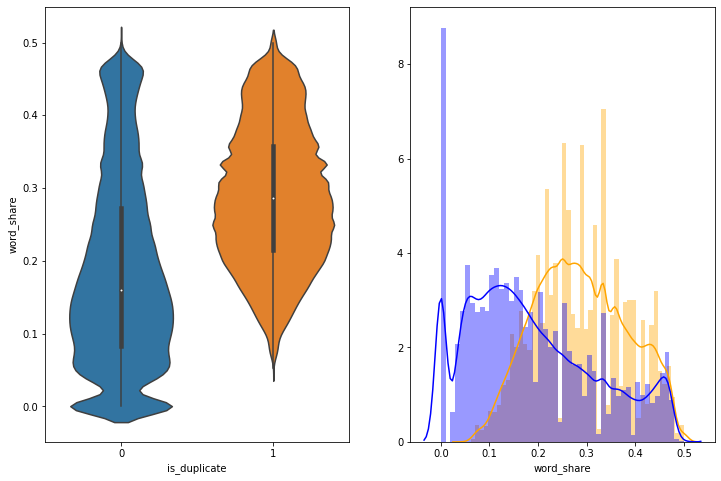

In [22]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_share',data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1]['word_share'][0:],label='1',color='orange')
sns.distplot(df[df['is_duplicate']==0]['word_share'][0:],label='0',color='blue')
plt.show()


* The distibution for normalized word_share have some overlap on the far right-hand side,i.e there are quite of question with high word similarity
* The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

# Feature : Word_common

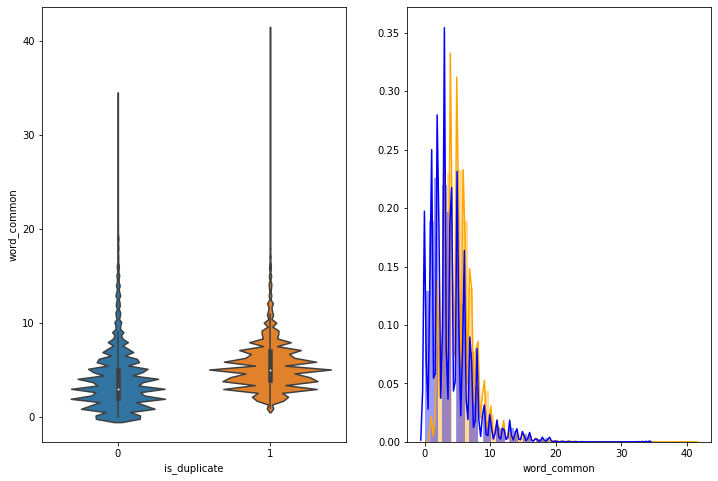

In [23]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='word_common',data=df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1]['word_common'][0:],label='1',color='orange')
sns.distplot(df[df['is_duplicate']==0]['word_common'][0:],label='0',color='blue')
plt.show()


# <p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

# EDA: Advanced Feature Extraction.

In [24]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud ,STOPWORDS
from os import path
from PIL import Image
import distance



In [25]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile("df_fe_without_preprocessing_train.csv"):
    df=pd.read_csv('df_fe_without_preprocessing_train.csv',encoding='utf8')
    df = df.fillna("")
    df.head()
else:
    print('get df_fe_without_preprocessing_train.csv from drive or run the previous notebooks')
    

In [26]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


# Preprocessing of Text.
* Preprocessing
    * Removing the HTML TAGS
    * Removing Punctuation
    * Performing Stemming
    * Removing Stopwords 
    * Expanding Contradiction etc .

In [27]:
#for getting result in 4 decimal points
Safe_div=0.0001
Stop_words=stopwords.words('english')
def preprocess(x):
    x=str(x).lower()
    x=x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    
    x = re.sub(r"([0-9]+)000000", r"\1m", x) #it will replace 000000 with m in any string x where m=million
                                                #Ex: x= 2000000 will be converted to 2m
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    stemming =PorterStemmer()
    pattern=re.compile('\W')
    #\W: : Matches any character which is not a word character.
    #This is the opposite of \w. If the ASCII flag is used this becomes the equivalent of [^a-zA-Z0-9_]
    #If the LOCALE flag is used, matches characters which are neither alphanumeric in the current locale nor the underscore.
    
    if type(x)==type(''): # for every x that is of type str.
        x=re.sub(pattern,' ',x)  # If the type of x is str then it will substitute the pattern with an empty space

    if type(x)==type(''):  #type('') >>output:str
        x=stemming.stem(x)
        exam=BeautifulSoup(x)
        x=exam.get_text()
    
    return x
#Beautiful Soup is a Python package for parsing HTML and XML documents 
#(including having malformed markup, i.e. non-closed tags, so named after tag soup).
#It creates a parse tree for parsed pages that can be used to extract data from HTML.
#We can also perform the same operation sing regex but unnecessary code will increase. 

In [28]:
#Example
x = 'This is the example x123@ and non!@#$%^&*'
pattern = re.compile('\W')
x = re.sub(pattern, ' ', x)
x

'This is the example x123  and non        '

In [29]:
type('')

str

* Function to compute and get the feature : With 2 parameter of Question1 and Question2

# Advance Feature Extraction (NLP and Fuzzy Features)

* Defination
    * Token: You get a token by splitting sentence a space
    * Stop_words: Stop words as per NLTK.
    * Word: A Token that is not a stop_word 

* Feature :
    * cwc_min: Ratio of common_words_count to min length of word count of Q1 and Q2
           cwc_min =common_word_count/(min(len(q1_words),len(q2_words))
    * cwc_max: Ratio of common_words_count to max length of word count of Q1 and Q2
           cwc_max =common_word_count/(max(len(q1_words),len(q2_words)) 
    
    * csc_min: Ratio of common_stop_count to min length of stops count of Q1 and Q2
           csc_min =common_stop_count/(min(len(q1_stops),len(q2_stops))
    * csc_max: Ratio of common_stop_count to max length of stops count of Q1 and Q2
           csc_max =common_stop_count/(max(len(q1_stops),len(q2_stops))
    
    * ctc_min: Ratio of common_token_count to min length of token count of Q1 and Q2
           ctc_min =common_token_count/(min(len(q1_tokens),len(q2_tokens))
    * ctc_max: Ratio of common_token_count to max length of token count of Q1 and Q2
           ctc_max =common_token_count/(max(len(q1_tokens),len(q2_tokens))      
           
    * last_words_eq: Check if Last word of both question is equal or not 
           last_words_eq=int(q1_token[-1]==q2_token[-1])
    * first_words_eq: Check if First word of both question is equal or not 
           first_words_eq=int(q1_token[-1]==q2_token[-1])
           
    * abs_len_diff: Abs length differnce 
           abs_len_diff=abs(len(q1_tokens)-len(q2_token))
           
    * mean_len: Average Token Lenght of both questions
           mean_len=((len(q1_tokens)+len(q2_tokens))/2 )
           
    * fuzz_ratio:
        * https://github.com/seatgeek/fuzzywuzzy#usage 
        * http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    * fuzz_partial_ratio:
        * https://github.com/seatgeek/fuzzywuzzy#usage 
        * http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    *  token_sort_ratio: 
        * https://github.com/seatgeek/fuzzywuzzy#usage
        * http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    * token_set_ratio:
        * https://github.com/seatgeek/fuzzywuzzy#usage 
        * http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/

    * longest_substr_ratio: Ratio of length longest common substring to min length of token count Q1 and Q2. 
        * longest_substr_ratio= len(longest common string)/(min(len(q1_tokens),len(q2_tokens))

***Q.) why we are using cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max?.I got the intuition behind why we are using fuzzy functions , but i am not getiing why we are using this.Can you give me the intuition behind why we are using this?***

**Ans. we come up with new features to improve performance of our model during feature engineering state. how to come up with new features? is problem specific and you have to feature engineer various features and test whether newly created features improve our model or not.If newly created features improve our model we keep those features in our dataset else we discard them.Its like Trial and error method.since it is quora similarity problem, we want to find how similar two questions are so it makes sense that we take ration of common word count, stop word count and token count. you can also come up with new features and check if these new features contribute anything to our model accuracy or not.**

In [30]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in Stop_words])
    q2_words = set([word for word in q2_tokens if word not in Stop_words])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in Stop_words])
    q2_stops = set([word for word in q2_tokens if word in Stop_words])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + Safe_div)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + Safe_div)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + Safe_div)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + Safe_div)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + Safe_div)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + Safe_div)

    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    # lcsubstrings returns longest common substring like if a= 'sedentar' and b = 'dentist' then it returns 'dent'
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
    #lambda function is taking x as input and returning x[0] as output from the function. 
    #To represent this we are using x:x[0] and the input that is sent to this lambda function is token_features.
    #The output obtained is then converted to list and stored in the dataframe. 
    #In the same way, remaining features are also stored. 
   


    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [31]:
if os.path.isfile('nlp_features_train1.csv'):
    df = pd.read_csv("nlp_features_train1.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv.zip")
    df = extract_features(df)
    df.to_csv("nlp_features_train1.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


# Analysing of extracted features

## Plotting Word Clouds
* Creating Word Cloud of Duplicates and Non-Duplicates Question Pairs
* We can observe the most frequent occuring words.

In [32]:
df_dupicates = df[df['is_duplicate']==1]
df_nondupicates = df[df['is_duplicate']==0]

#Converting 2d array of q1 and q2 and Flatten the array : like {{1,2},{3,4}} to {1,2,3,4}
p=np.dstack([df_dupicates['question1'],df_dupicates['question2']]).flatten()
n=np.dstack([df_nondupicates['question1'],df_nondupicates['question2']]).flatten()
    
print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file 
np.savetxt('train_p.txt',p,delimiter=' ',fmt='%s',encoding='utf-8')
np.savetxt('train_n.txt',n,delimiter=' ',fmt='%s',encoding='utf-8')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [33]:
d=path.dirname('.')   #'.' represents the current working directory.

textp_w=open(path.join(d,'train_p.txt',),encoding='utf-8').read()
textn_w=open(path.join(d,'train_n.txt'),encoding='utf-8').read()
stopwords=set(Stop_words)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")
stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
#stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")

print('total number of words in duplicates pair question:',len(textp_w))
print('total number of words in non duplicates pair question:',len(textn_w))

total number of words in duplicates pair question: 16110954
total number of words in non duplicates pair question: 33201584


# Word Cloud generated from pair question's Text

Word cloud for Duplicates Question pair


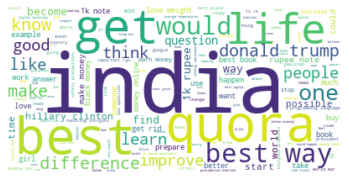

In [35]:
#WordCloud is the pictorial representation of showing the important features 
#i.e feature which are very important are having the large font size.
#The good features helps us imporving the metric we are using.

wc=WordCloud(background_color='white',max_words=len(textp_w),stopwords=Stop_words)
wc.generate(textp_w)
print("Word cloud for Duplicates Question pair")
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

Word cloud for non Duplicates Question pair


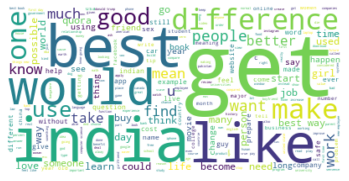

In [36]:
wc=WordCloud(background_color='white',max_words=len(textn_w),stopwords=Stop_words)
wc.generate(textn_w)
print("Word cloud for non Duplicates Question pair")
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

# Pair Plot of feature ['ctc_min','cwc_min','csc_min','token_sort_ratio']

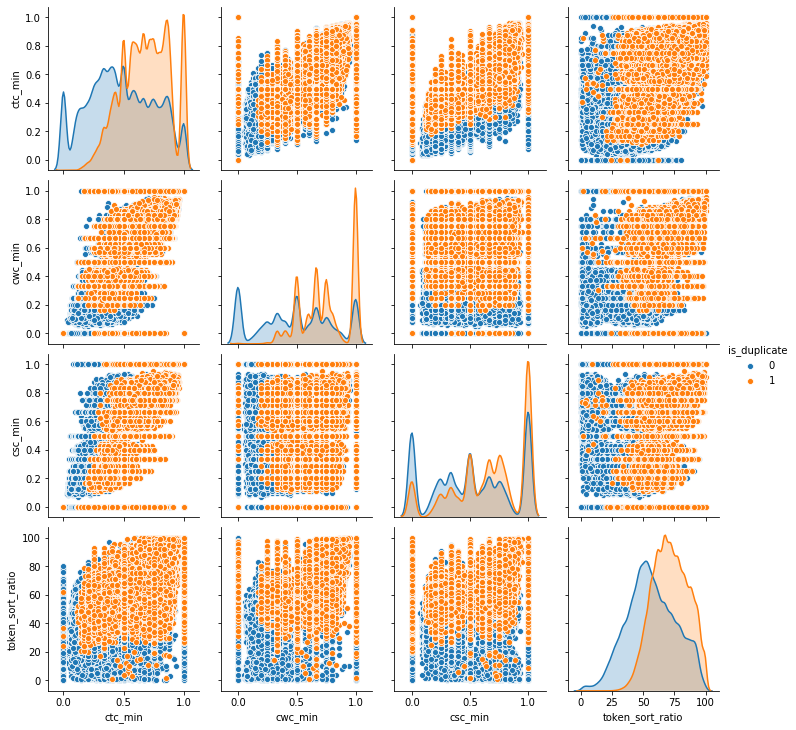

In [37]:
n=df.shape[0]
sns.pairplot(df[['ctc_min','cwc_min','csc_min','token_sort_ratio','is_duplicate']][0:n],hue='is_duplicate',vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

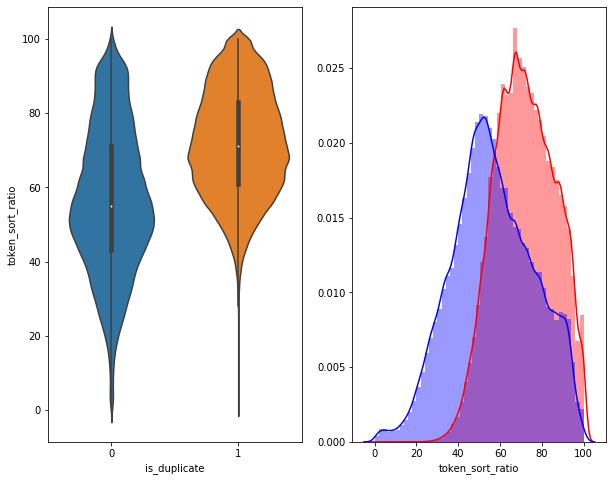

In [38]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='token_sort_ratio',data=df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['token_sort_ratio'][0:],label='1',color='red')
sns.distplot(df[df['is_duplicate']==0]['token_sort_ratio'][0:],label='0',color='blue')
plt.show()

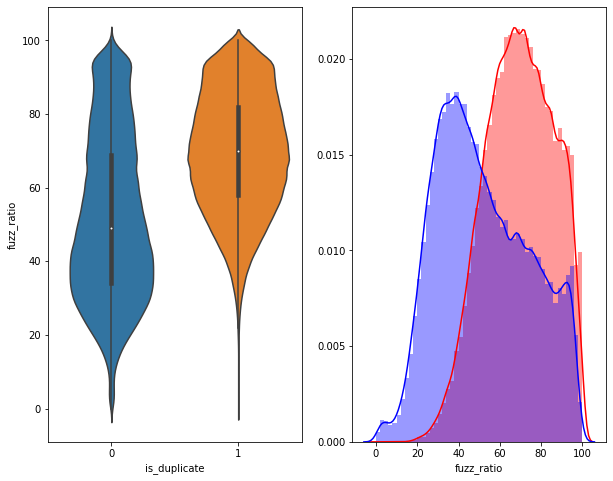

In [39]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate',y='fuzz_ratio',data=df[0:])
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1.0]['fuzz_ratio'][0:],label='1',color='red')
sns.distplot(df[df['is_duplicate']==0]['fuzz_ratio'][0:],label='0',color='blue')
plt.show()

In [40]:
# Using Tsne for Dimensionality reduction for 15 features (Generated after cleaning the data) to 3 dimension
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
dfp_subsampled=df[0:5000] # picking 5000 data points
X=MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y=dfp_subsampled['is_duplicate'].values

In [41]:
tsne2d=TSNE(n_components=2,
            init='random',
            random_state=101,
            method='barnes_hut',#barnes_hut is one of the ways in which the t-SNE algorithm can be implemented. 
            n_iter=1000,    # By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time.
            verbose=2,
            angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.156s...
[t-SNE] Computed neighbors for 5000 samples in 0.604s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131928
[t-SNE] Computed conditional probabilities in 0.620s
[t-SNE] Iteration 50: error = 81.3523254, gradient norm = 0.0532696 (50 iterations in 3.498s)
[t-SNE] Iteration 100: error = 70.6837692, gradient norm = 0.0106284 (50 iterations in 2.383s)
[t-SNE] Iteration 150: error = 69.0254211, gradient norm = 0.0053264 (50 iterations in 2.269s)
[t-SNE] Iteration 200: error = 68.2494278, gradient norm = 0.0047586 (50 iterations in 2.483s)
[t-SNE] Iteration 250: error = 67.7707367, gradient norm = 0.0034672

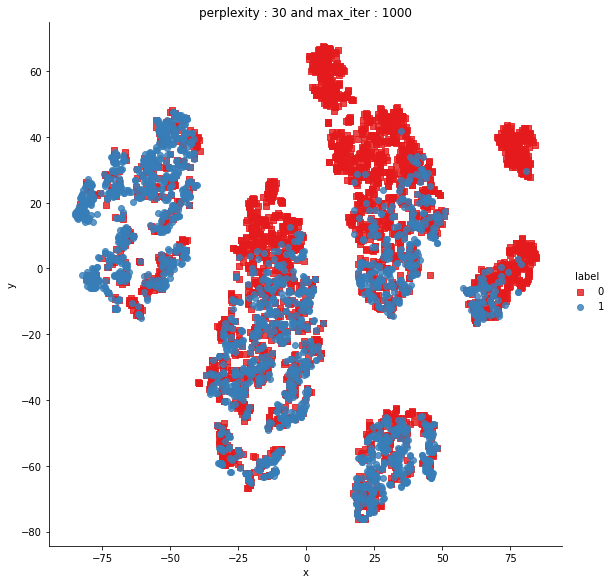

In [42]:
df=pd.DataFrame({'x':tsne2d[:,0],'y':tsne2d[:,1],'label':y})
#draw the plot in appropriate place in the grid
sns.lmplot(data=df,x='x',y='y',hue='label',fit_reg=False,size=8,palette='Set1',markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [43]:
tsne3d=TSNE(n_components=3,
            init='random',
            random_state=101,
            method='barnes_hut',
            n_iter=1000,
            verbose=2,
            angle=0.5).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.046s...
[t-SNE] Computed neighbors for 5000 samples in 0.684s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131928
[t-SNE] Computed conditional probabilities in 0.386s
[t-SNE] Iteration 50: error = 80.5673904, gradient norm = 0.0322042 (50 iterations in 9.207s)
[t-SNE] Iteration 100: error = 69.4761353, gradient norm = 0.0034215 (50 iterations in 4.794s)
[t-SNE] Iteration 150: error = 68.1062622, gradient norm = 0.0016603 (50 iterations in 4.960s)
[t-SNE] Iteration 200: error = 67.5317230, gradient norm = 0.0011550 (50 iterations in 4.820s)
[t-SNE] Iteration 250: error = 67.2180023, gradient norm = 0.0008714

In [44]:
tracel =go.Scatter3d(x=tsne3d[:,0]
                     ,y=tsne3d[:,1],
                     z=tsne3d[0:,2],
                     mode='markers',
                     marker=dict(sizemode='diameter',
                                 color = y,
                                 colorscale = 'Portland',
                                 colorbar = dict(title = 'duplicate'),
                                 line=dict(color='rgb(255, 255, 255)'),
                                 opacity=0.75)
                    )
data=[tracel]
layout=dict(height=800,width=800,title='3d embedding with engineered features')
fig=dict(data=data,layout=layout)
py.iplot(fig,filename='3DBubble')

# Featurizing text data with tfidf weighted word-vectors

In [45]:
#pip install spacy 

Note: you may need to restart the kernel to use updated packages.


In [46]:
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
import numpy as np
import time 
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

import os
import re
import sys
from tqdm import tqdm
import spacy
# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721

In [47]:
#avoiding decoding problems
df=pd.read_csv('train.csv.zip')
# encode question to unicode
# https://stackoverflow.com/a/6812069
df['question1']=df['question1'].apply(lambda x:str(x))
df['question2']=df['question2'].apply(lambda x:str(x))

In [48]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Why we not use BOW instead of tf-idf word vector?
#Because here semantics of the text might be important.
#And as we are using the word_vectors we are incorporating 
#some semantic meaning of the sentence in our feature vectors,
#which is difficult while using BOW

# merging text 
# Explaining for merging of question 1 nd 2 .
#it is a bad idea to encode each column separately. 
#Consider a question which is in both columns(q1 and q2) that is "what is graphene?" 
#if we vectorize after combining both columns, then vectorizing the q1 and q2 will result in the same vector. 
#if we vectorize the columns separately then these wors may have different dimensions in both vectorizations
#hence the vectors will be different even though these 2 questions were an exact copy.
#Hence we prefer doing vectorization after combining the corpus, to achieve same dimension for each word in the corpus.

 
questions = list(df['question1'])+list(df['question2'])
tf_idf=TfidfVectorizer(lowercase=False)
tf_idf.fit_transform(questions)


# dict key:word and value:tf-idf score
word2_tf_idf=dict(zip(tf_idf.get_feature_names(),tf_idf.idf_))
#zip is used to bind both lists together. 
#Then using dict makes feature names as keys and thier corresponding idf scores as values.

* After we find Tf-idf scores ,we convert each question to a weighted average of word2vec vectors by these scores 
* We are using a pre-trained **GLOVE** model which come free with "*Spacy*"(https://spacy.io/usage/vectors-similarity)
* It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

## use of glove
**The goal of Glove is very straightforward, i.e. to enforce the word vectors to capture sub-linear relationships in the vector space. Thus, it proves to perform better than Word2vec in the word analogoy tasks.
Glove adds some more practical meaning into word vectors by considering the relationships between word pair and word pair rather than word and word.
Glove gives lower weight for highly frequent word pairs so as to prevent the meaningless stop words like “the”, “an” will not dominate the training progress**

In [50]:
#!python -m spacy download en_core_web_sm

In [51]:
# "en_vectors_web_sm", which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')
vecs1 = []
for q1 in tqdm(list(df['question1'])): # tqdm is used to print the progress bar
    doc1 = nlp(q1) 
    #nlp(q1) will create language Language object containing all components and data needed to process text
    # 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2_tf_idf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)  #mean method is used for calculating the AVG W2V. 
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)
print(len(df['q1_feats_m']))


100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:13:20<00:00, 91.87it/s]


404290


# Explaining  above code : 
a=np.zeros((2,3))

b=np.array([1,2,3])

c=np.array([3,4,5])

idf_b=2

idf_c=3

b_idf=b*idf_b>>output:arry([2,4,6]])

c_idf=c*idf_c>>output:arrya([2,4,6)])

a+=b_idf

a+=c_idf

a >>output :array([[11,16,21],
             [11,16,21]])

a.mean(axis=0)

a >>output: array([11,16,21])



In [89]:
# "en_vectors_web_sm", which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')
vecs1 = []
for q1 in tqdm(list(df['question1'])): # tqdm is used to print the progress bar
    doc1 = nlp(q1) 
    # 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    weight_sum=0
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2_tf_idf[str(word1)]
        except:
            idf = 0
        # compute final vec
        tf = (doc1.count(word1)/len(doc1))
        tf_idf=idf*tf
        mean_vec1 += vec1 * tf_idf
        weight_sum+=tf_idf
    if weight_sum!=0:
        mean_vec1/=weight_sum
    #mean_vec1 = mean_vec1.mean(axis=0)  #mean method is used for calculating the AVG W2V. 
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)
print(len(df['q1_feats_m']))


  0%|                                                                                       | 0/404290 [00:02<?, ?it/s]


TypeError: must be str, not spacy.tokens.token.Token

In [123]:
for q1 in tqdm(list(df['question1'][:1])): # tqdm is used to print the progress bar
#for q1 in tqdm((df['question1'][:1])): # tqdm is used to print the progress bar
    print(q1)
    doc=nlp(q1)
    print(doc)
    for word in doc:
        print(word)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

What is the step by step guide to invest in share market in india?


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]

What is the step by step guide to invest in share market in india?
What
is
the
step
by
step
guide
to
invest
in
share
market
in
india
?


In [52]:
vecs2 = []
for q2 in tqdm(list(df['question2'])): # tqdm is used to print the progress bar
    doc2 = nlp(q2) 
    # 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector  #converting each word in doc1 into vector
        # fetch df score
        try:
            idf = word2_tf_idf[str(word2)]
        except:
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)
print(len(df['q2_feats_m']))


100%|████████████████████████████████████████████████████████████████████████| 404290/404290 [1:07:26<00:00, 99.91it/s]

404290


In [53]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train1.csv'):
    dfnlp=pd.read_csv('nlp_features_train1.csv',encoding='latin-1')
else:
    print('download nlp_features_train.csv from drive or run above notebook')
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df_pre_process=pd.read_csv('df_fe_without_preprocessing_train.csv',encoding='latin-1')
else: 
    print("download df_fe_without_preprocessing_train.csv from drive or run above notebook again")
    
    
    

In [54]:
df1=dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2=df_pre_process.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3=df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [55]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [56]:
# dataframe of nlp features
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_common,word_total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [57]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,79.078368,15.782015,37.059933,-28.544889,4.867470,16.195764,-23.889924,19.217545,45.637697,-44.844444,...,-15.927716,-34.502119,-37.652297,-24.222526,-6.814603,1.565480,0.176575,-12.006127,-13.089393,-2.580190
1,18.990895,48.390130,14.231484,-12.000772,-2.324461,-20.050932,-16.054571,-15.817234,3.254206,-39.863569,...,-1.317570,-34.506621,-42.934304,-23.459040,1.949564,45.108898,43.110095,-36.803870,-8.712237,-22.469971
2,54.692787,-3.394840,-5.179496,-21.129702,-1.274350,-1.072263,-6.901485,4.729378,12.129097,-55.807836,...,-15.140935,-7.417957,-19.519384,-18.313298,-12.290460,27.515270,2.684604,21.282424,3.060845,-27.171151
3,-38.413672,-20.697513,35.373624,6.285544,-27.103690,8.391100,-3.117369,-53.872667,6.734537,-25.842009,...,-7.413968,-12.871087,-31.546903,3.438217,-13.291763,13.850608,-1.497392,-20.858584,15.322562,-21.362451
4,92.387053,74.556795,13.198951,-4.791852,-51.456352,-3.113267,-41.945073,26.884295,18.497074,-24.449817,...,-12.466644,-57.505525,-100.352810,-21.944372,-51.781225,10.135160,55.911919,-73.901470,20.286852,13.582452


In [58]:
# Questions 1 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,65.801323,15.163422,28.238266,-22.443852,-1.128925,14.044991,-19.552763,23.298142,33.598363,-34.684075,...,-13.240537,-35.406896,-33.057640,-22.903016,-6.279674,-3.470415,-12.132650,-8.762911,-16.139722,-8.468421
1,21.181424,44.148348,-5.684418,-28.518000,-30.621347,7.486889,-16.820549,3.151197,11.878596,-13.489625,...,-37.242321,-31.066501,-45.401841,-23.039140,-5.305935,19.393052,16.864326,-17.193637,19.457988,-29.883964
2,30.072109,1.884914,8.957100,-17.541207,5.527257,11.008258,-17.920209,-8.347894,31.698695,-29.361526,...,-47.572800,-25.605731,-2.952524,-14.122942,-15.086718,18.696399,-10.663266,-16.244405,9.462036,-27.573797
3,-6.790537,8.109635,-11.995347,5.544092,2.526908,24.105819,-3.365436,-29.804845,13.855379,-30.282178,...,-6.002136,-17.760930,-8.941548,-5.513345,9.070530,-11.465429,-10.020494,6.949860,-11.345790,-8.980606
4,7.216287,18.788520,-4.488336,3.660822,-3.195826,25.894172,-8.917328,25.624590,2.440142,-19.258449,...,-11.907321,-20.781592,-21.847624,-19.488214,-27.055909,-10.091494,-10.345063,9.702322,6.626536,-13.139180


In [59]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [60]:
# stroing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1 =df1.merge(df2,on='id',how='left')
    df2=df3_q1.merge(df3_q2,on='id',how='left')    
    result=df1.merge(df2,on='id',how='left',)
    result.to_csv('final_features.csv')

In [61]:
pd.read_csv('final_features.csv')

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,...,-13.240537,-35.406896,-33.057640,-22.903016,-6.279674,-3.470415,-12.132650,-8.762911,-16.139722,-8.468421
1,1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,...,-37.242321,-31.066501,-45.401841,-23.039140,-5.305935,19.393052,16.864326,-17.193637,19.457988,-29.883964
2,2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,...,-47.572800,-25.605731,-2.952524,-14.122942,-15.086718,18.696399,-10.663266,-16.244405,9.462036,-27.573797
3,3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-6.002136,-17.760930,-8.941548,-5.513345,9.070530,-11.465429,-10.020494,6.949860,-11.345790,-8.980606
4,4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,...,-11.907321,-20.781592,-21.847624,-19.488214,-27.055909,-10.091494,-10.345063,9.702322,6.626536,-13.139180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404285,404285,404285,0,0.857131,0.857131,0.999980,0.833319,0.846147,0.785709,1.0,...,-35.999230,-26.640160,-4.867239,-4.787561,-43.159716,23.102501,-5.638421,-17.429468,-16.461461,4.291889
404286,404286,404286,1,0.666644,0.666644,0.599988,0.599988,0.624992,0.555549,1.0,...,-9.761501,-20.870629,-3.179662,-9.450288,-3.566819,15.738623,7.155592,9.513552,-4.558735,-27.788374
404287,404287,404287,0,0.999900,0.499975,0.999950,0.666644,0.749981,0.749981,1.0,...,12.860359,1.326388,-0.354495,-6.018992,-3.941536,-2.423724,-6.727008,-1.179390,-18.719300,-5.664255
404288,404288,404288,0,0.000000,0.000000,0.124998,0.099999,0.058823,0.040000,0.0,...,-34.161962,-31.072801,-71.213648,-48.083287,-58.346491,5.624157,-23.616595,3.903139,0.777782,-49.859409


# Machine Learning Model 

In [62]:
#pip install mlxtend

In [63]:
import os
import re
import time
import math
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sqlite3
import datetime as dt
from sqlalchemy import create_engine

from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from mlxtend.classifier import StackingClassifier


from sklearn.metrics import confusion_matrix
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from collections import Counter
from collections import defaultdict
from scipy.sparse import hstack


# Reading data from file and storing table into sql table

In [64]:
#a= pd.read_csv('final_features.csv')
#list(a.columns)

In [65]:
#creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine=create_engine('sqlite:///train.db')
    start=dt.datetime.now()
    chunksize=180000 #Now to do that, we're doing it in chunks. 
                     #We're iterating over dataframe and considering only 180000(chunksize) 
                     #at one time to convert csv to db file.For first iteration,
                     #it will consider rows from 1 to 180000 and then from 180000 to 180000*2 and so on.
    j=0
    index_start=1
    for df in pd.read_csv('final_features.csv',names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index+=index_start
        j+=1
        print('{}rows'.format(j*chunksize))
        df.to_sql('data',disk_engine,if_exists='append')
        index_start=df.index[-1]+1 #index_start = df.index[-1] + 1 means index_start is given the next number after the last element
                                   # of the df.index.For example, if the last index of df is 1000, index_start will be 1001.

Explanation of code block above:
1. We're here setting the value of dataframe index
2. j is iteration counter. Here, we're incrementing it.
3. It's just a print statement
4. This is the main line. Here, we're coverting those 180000 rows(chunksize) that df variable holds for current iteration into db file. And we're checking if db file exists, then just append these rows to that file so that we don't have separate db files for each iteration.
5. Just assigning new value of index_start on the basis of current iteration.
 

In [66]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """creating db connection to SQLite database
    specified by db_file 
    :param db_file: database_file
    :return Connection obeject or none"""
    try: 
        conn =sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
    return None
def Check_table_exist(dbcon):
    cursor=dbcon.cursor()
    str="select name from Sqlite_master where type='table'"
    table_name=cursor.execute(str)
    print('Table in the database:')
    tables=table_name.fetchall()
    print(tables[0][0])
    return(len(tables))
        

In [67]:
read_db ='train.db'
conn_r=create_connection(read_db)
Check_table_exist(conn_r)
conn_r.close()


Table in the database:
data


In [68]:
if os.path.isfile(read_db):
    conn_r=create_connection(read_db)
    if conn_r is not None:
        #for selecting first 1m Rows 
        #data =pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""",conn_r)
        
        # for selecting random points
        data =pd.read_sql_query("""SELECT * FROM data ORDER BY RANDOM() LIMIT 100001;""",conn_r)
        conn_r.commit()
        conn_r.close()

In [69]:
data.head()

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,86_y,87_,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,437347,257345.0,257345,1,0.499987500312492,0.499987500312492,0.199996000079998,0.199996000079998,0.333329629670781,0.333329629670781,...,22.4185033738613,-9.93104410171509,-6.04093503952026,-15.1684210002422,-10.1542371511459,50.8691209554672,-6.64309411495924,13.486953124404,8.52591973543167,-18.4887893348932
1,913093,373091.0,373091,1,0.66664444518516,0.499987500312492,0.399992000159997,0.399992000159997,0.499993750078124,0.39999600004,...,16.9693713188171,-6.65706861764193,9.81858831644058,0.752052828669548,-6.02200688421726,18.8895916640759,-0.277379870414734,12.2278628945351,1.03548395633697,6.55830937623978
2,508761,328759.0,328759,0,0.499991666805553,0.428565306209911,0.499975001249937,0.166663888935184,0.444439506227709,0.307689940846609,...,-21.0295848995447,-6.66368062794209,-22.665320135653,-11.231394495815,-23.7259985655546,-2.17873194813728,-13.1847160458565,-3.23591198027134,-9.20510917901993,4.37190979719162
3,396343,216341.0,216341,0,0.0,0.0,0.999950002499875,0.66664444518516,0.66664444518516,0.399992000159997,...,-9.47168290615082,-9.37105548381805,-8.14055393636227,-22.0171903073788,-9.10533699393273,4.1681716889143,5.63161391019821,12.5599037408829,-14.8989332616329,-21.8964804708958
4,115040,115038.0,115038,1,0.999966667777741,0.999966667777741,0.749981250468738,0.599988000239995,0.857130612419823,0.749990625117186,...,3.44676306843758,1.50663596391678,-1.55767729878426,-8.92140523716807,3.48671460151672,10.3974946141243,-0.843488216400147,4.86623024940491,-1.34890365600586,-13.4370348155499


In [70]:
data.shape

(100001, 222)

In [71]:
#remove the first row
data.drop(data.index[0],inplace=True)
y_true=data['is_duplicate']
data.head()

,index,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,86_y,87_,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,913093,373091.0,373091,1,0.66664444518516,0.499987500312492,0.399992000159997,0.399992000159997,0.499993750078124,0.39999600004,...,16.9693713188171,-6.65706861764193,9.81858831644058,0.752052828669548,-6.02200688421726,18.8895916640759,-0.277379870414734,12.2278628945351,1.03548395633697,6.55830937623978
2,508761,328759.0,328759,0,0.499991666805553,0.428565306209911,0.499975001249937,0.166663888935184,0.444439506227709,0.307689940846609,...,-21.0295848995447,-6.66368062794209,-22.665320135653,-11.231394495815,-23.7259985655546,-2.17873194813728,-13.1847160458565,-3.23591198027134,-9.20510917901993,4.37190979719162
3,396343,216341.0,216341,0,0.0,0.0,0.999950002499875,0.66664444518516,0.66664444518516,0.399992000159997,...,-9.47168290615082,-9.37105548381805,-8.14055393636227,-22.0171903073788,-9.10533699393273,4.1681716889143,5.63161391019821,12.5599037408829,-14.8989332616329,-21.8964804708958
4,115040,115038.0,115038,1,0.999966667777741,0.999966667777741,0.749981250468738,0.599988000239995,0.857130612419823,0.749990625117186,...,3.44676306843758,1.50663596391678,-1.55767729878426,-8.92140523716807,3.48671460151672,10.3974946141243,-0.843488216400147,4.86623024940491,-1.34890365600586,-13.4370348155499
5,99427,99425.0,99425,0,0.0,0.0,0.399992000159997,0.19999800002,0.181816528940646,0.0909086776878287,...,-27.9017169913277,-12.827051050961,-56.74072381109,-42.1071487665176,-52.7892564833164,2.38788843154907,-11.09539587982,-16.3051333390176,12.2974866330624,-34.9387941360474


In [72]:
data.drop(['Unnamed: 0', 'id','index','is_duplicate'],axis=1,inplace=True)
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.66664444518516,0.499987500312492,0.399992000159997,0.399992000159997,0.499993750078124,0.39999600004,1.0,0.0,2.0,9.0,...,16.9693713188171,-6.65706861764193,9.81858831644058,0.752052828669548,-6.02200688421726,18.8895916640759,-0.277379870414734,12.2278628945351,1.03548395633697,6.55830937623978
2,0.499991666805553,0.428565306209911,0.499975001249937,0.166663888935184,0.444439506227709,0.307689940846609,0.0,1.0,4.0,11.0,...,-21.0295848995447,-6.66368062794209,-22.665320135653,-11.231394495815,-23.7259985655546,-2.17873194813728,-13.1847160458565,-3.23591198027134,-9.20510917901993,4.37190979719162
3,0.0,0.0,0.999950002499875,0.66664444518516,0.66664444518516,0.399992000159997,0.0,1.0,2.0,4.0,...,-9.47168290615082,-9.37105548381805,-8.14055393636227,-22.0171903073788,-9.10533699393273,4.1681716889143,5.63161391019821,12.5599037408829,-14.8989332616329,-21.8964804708958
4,0.999966667777741,0.999966667777741,0.749981250468738,0.599988000239995,0.857130612419823,0.749990625117186,1.0,1.0,1.0,7.5,...,3.44676306843758,1.50663596391678,-1.55767729878426,-8.92140523716807,3.48671460151672,10.3974946141243,-0.843488216400147,4.86623024940491,-1.34890365600586,-13.4370348155499
5,0.0,0.0,0.399992000159997,0.19999800002,0.181816528940646,0.0909086776878287,0.0,0.0,11.0,16.5,...,-27.9017169913277,-12.827051050961,-56.74072381109,-42.1071487665176,-52.7892564833164,2.38788843154907,-11.09539587982,-16.3051333390176,12.2974866330624,-34.9387941360474


# Converting String to numerics

In [73]:
#after we read from sql table each entry was read it as a string
# we convert all the features into numeric before we apply any model
cols=list(data.columns)
for i in cols:
    data[i]=data[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [74]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
y_true=list(map(int,y_true.values))

# Random train test split(70:30)

In [75]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3)
X_train,X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

print('Number of data points in train data:',X_train.shape)
print('Number of data points in cv data:',X_cv.shape)

print('Number of data points in test data:',X_test.shape)

Number of data points in train data: (56000, 218)
Number of data points in cv data: (14000, 218)
Number of data points in test data: (30000, 218)


In [76]:
print("*"*10,'Distribution of output varaible in train data ',"*"*10)
train_distr=Counter(y_train)
train_len=len(y_train)
print("Class 0:",int(train_distr[0])/train_len,'Class 1:',int(train_distr[1])/train_len)

print('Distribution of output varaible in test data ')
test_distr=Counter(y_test)
test_len=len(y_test)
print("*"*10,"Class 0:",int(test_distr[0])/test_len,'Class 1:',int(test_distr[1])/test_len,"*"*10)

print('Distribution of output varaible in cv data ')
cv_distr=Counter(y_cv)
cv_len=len(y_cv)
print("*"*10,"Class 0:",int(cv_distr[0])/cv_len,'Class 1:',int(cv_distr[1])/cv_len,"*"*10)

********** Distribution of output varaible in train data  **********
Class 0: 0.6318571428571429 Class 1: 0.36814285714285716
Distribution of output varaible in test data 
********** Class 0: 0.6318666666666667 Class 1: 0.3681333333333333 **********
Distribution of output varaible in cv data 
********** Class 0: 0.6318571428571429 Class 1: 0.36814285714285716 **********


In [77]:
#Creating a fucntion to plot confusion matrix
def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)
    #C=2,2 matrix ,each cell (i,j)represents number of points of class i are predicted class j 
    A=(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with sum of elements in that column
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    B=(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    plt.figure(figsize=(20,4))
    
    labels=[1,2]
    #Representing A in heatmapformat
    cmap=sns.light_palette('red')
    plt.subplot(1,3,1)
    sns.heatmap(C,annot=True,fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predictd Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1,3,2)
    sns.heatmap(B,annot=True,fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predictd Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1,3,3)
    sns.heatmap(A,annot=True,fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predictd Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Building a Random Model (Finding Worst-case log-loss)


Log loss on Test Data using Random model: 0.8852589162195535


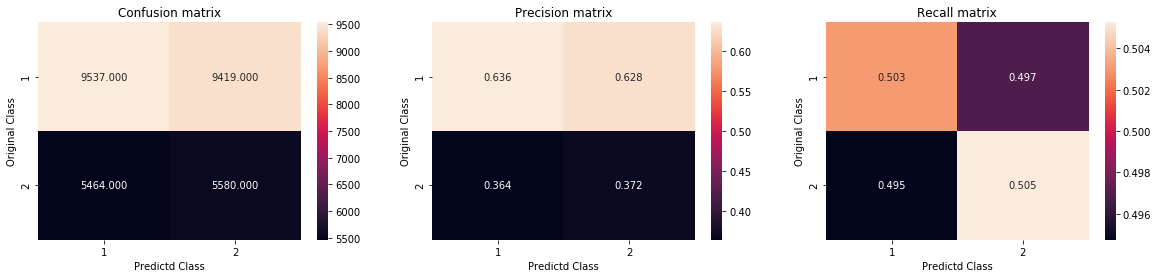

In [78]:
# We need to generate 9 numbers and the sum of numbers be 1
# one solution to do is to generate 9 numbers and divide each of the numbers by sum
# # we create a output array that has exactly same size as the test data
# ref: https://stackoverflow.com/a/18662466/4084039

predicted_y=np.zeros((test_len,2))# is used to create an array of zeros of size (test_len, 2). 
for i in range(test_len):
    rand_probs=np.random.rand(1,2) #is used to generate random numbers of shape [1,2].
    predicted_y[i]=((rand_probs/sum(sum(rand_probs)))[0]) #is used to normalize the probabilities so that they sum to 1
    #for ith datapoint rand_probs = [[0.12156421 0.82328621]] 
    #then sum(rand_probs) returns [0.12156421 0.82328621] (single square bracket). 
    #then we are taking sum of this i.e print(sum(sum(rand_probs))) returns 0.9448504287035864.
    #now we divide this sum with each element. so final answer is [[0.12865974 0.87134026]].
print("Log loss on Test Data using Random model:",log_loss(y_test,predicted_y,eps=1e-15))

predicted_y=np.argmax(predicted_y,axis=1)
plot_confusion_matrix(y_test,predicted_y)


# Logistic Regression with hyperparameter tuning 

For value of alpha = 1e-05 The log loss is : 0.44489140250067727
For value of alpha = 0.0001 The log loss is : 0.4459956231289562
For value of alpha = 0.001 The log loss is : 0.4444186827528574
For value of alpha = 0.01 The log loss is : 0.422653508949224
For value of alpha = 0.1 The log loss is : 0.43672784108917817
For value of alpha = 1 The log loss is : 0.4715753048867664
For value of alpha = 10 The log loss is : 0.5207124115629839


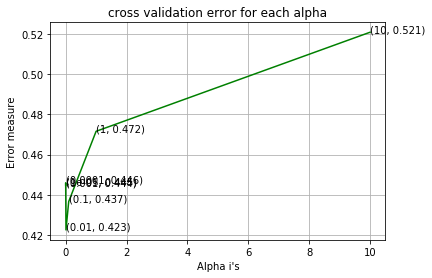

For value of best alpha = 0.01 The log train  loss is : 0.42100107780832957
For value of best alpha = 0.01 The log test  loss is : 0.4309831368643644
Total number of data points : 30000


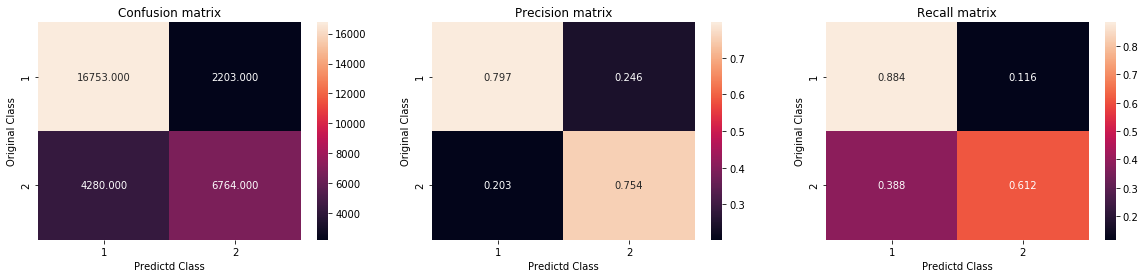

In [79]:
alpha=[10 ** x for x in range(-5,2)] # hyperparameter for SGD classifier

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

log_error=[]
for i in  alpha:
    clf=SGDClassifier(alpha=i,loss='log',penalty='l2',random_state=42)
    clf.fit(X_train,y_train)
    
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(X_train,y_train)
    predict_y=sig_clf.predict_proba(X_cv)
    log_error.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    #labels=clf.classes_:It is to make the function understand, how many classes are there.
    print("For value of alpha =",i,"The log loss is :",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    
fig,ax=plt.subplots()
ax.plot(alpha,log_error,c='g')
for i,txt in enumerate(np.round(log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)),(alpha[i],log_error[i]))
plt.grid()
plt.title('cross validation error for each alpha')
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_aplha=np.argmin(log_error)
clf=SGDClassifier(alpha=alpha[best_aplha],penalty='l2',loss='log',random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)
predict_y=sig_clf.predict_proba(X_train)
print("For value of best alpha =",alpha[best_aplha],"The log train  loss is :",log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y=sig_clf.predict_proba(X_test)

print("For value of best alpha =",alpha[best_aplha],"The log test  loss is :",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))
predicted_y=np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test,predicted_y)

# Linear SVM with Hypaeparameter Tuning

For value of alpha = 1e-05 The log loss is : 0.4558771290601397
For value of alpha = 0.0001 The log loss is : 0.446471871046049
For value of alpha = 0.001 The log loss is : 0.4489885418847621
For value of alpha = 0.01 The log loss is : 0.43311473036098763
For value of alpha = 0.1 The log loss is : 0.4418069482183752
For value of alpha = 1 The log loss is : 0.47218235640816864
For value of alpha = 10 The log loss is : 0.518102608140853


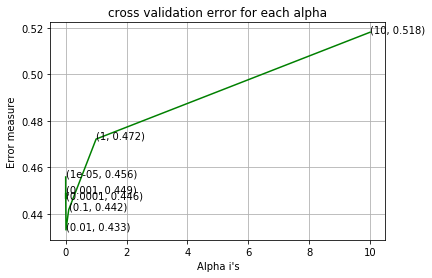

For value of best alpha = 0.01 The log train  loss is : 0.42188819203281197
For value of best alpha = 0.01 The log test  loss is : 0.43157725194168367
Total number of data points : 30000


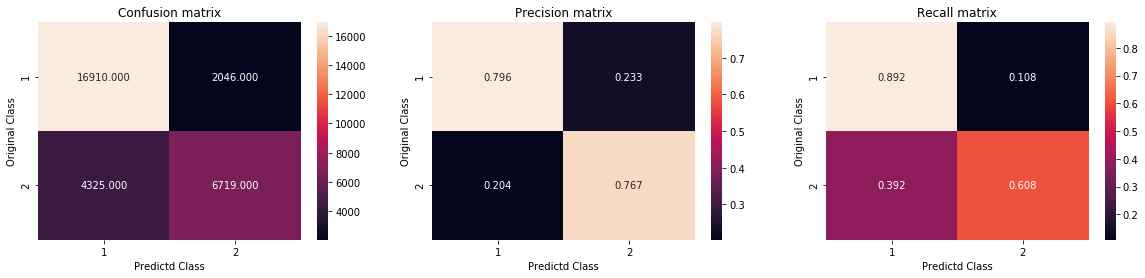

In [80]:
alpha=[10 ** x for x in range(-5,2)] # hyperparameter for SGD classifier

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

log_error=[]
for i in  alpha:
    clf=SGDClassifier(alpha=i,loss='hinge',penalty='l2',random_state=42)
    clf.fit(X_train,y_train)
    
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid',cv='prefit')
    sig_clf.fit(X_cv,y_cv)
    predict_y=sig_clf.predict_proba(X_cv)
    log_error.append(log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    #labels=clf.classes_:It is to make the function understand, how many classes are there.
    print("For value of alpha =",i,"The log loss is :",log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    
fig,ax=plt.subplots()
ax.plot(alpha,log_error,c='g')
for i,txt in enumerate(np.round(log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)),(alpha[i],log_error[i]))
plt.grid()
plt.title('cross validation error for each alpha')
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_aplha=np.argmin(log_error)
clf=SGDClassifier(alpha=alpha[best_aplha],penalty='l2',loss='hinge',random_state=42)
clf.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y=sig_clf.predict_proba(X_train)
print("For value of best alpha =",alpha[best_aplha],"The log train  loss is :",log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y=sig_clf.predict_proba(X_test)
print("For value of best alpha =",alpha[best_aplha],"The log test  loss is :",log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

predicted_y=np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test,predicted_y)

# Xgboost 

In [81]:
pip install xgboost

In [82]:
aram={}
aram['objective']='binary:logistic'
aram['eval_metric']='logloss'
aram['eta']=0.02
aram['max_depth']=4
aram

{'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'eta': 0.02,
 'max_depth': 4}

In [83]:
import xgboost as xgb
params={}
params['objective']='binary:logistic'
params['eval_metric']='logloss'
params['eta']=0.02
params['max_depth']=4
#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed
d_train=xgb.DMatrix(X_train,label=y_train)
d_cv=xgb.DMatrix(X_cv,label=y_cv)##convert train and test and cv data to DMatrix format
d_test=xgb.DMatrix(X_test,label=y_test)

watchlist=[(d_train,'train'),(d_cv,'valid')]#It used to specify validations set to watch the performance.
bst=xgb.train(params,d_train,400,watchlist,early_stopping_rounds=20,verbose_eval=10)
xgbmat=xgb.DMatrix(X_train,y_train)
predict_y=bst.predict(d_test)
print('The log loss is :',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))

[0]	train-logloss:0.68476	valid-logloss:0.68478
[10]	train-logloss:0.61479	valid-logloss:0.61526
[20]	train-logloss:0.56296	valid-logloss:0.56381
[30]	train-logloss:0.52423	valid-logloss:0.52549
[40]	train-logloss:0.49523	valid-logloss:0.49676
[50]	train-logloss:0.47209	valid-logloss:0.47392
[60]	train-logloss:0.45355	valid-logloss:0.45568
[70]	train-logloss:0.43849	valid-logloss:0.44101
[80]	train-logloss:0.42615	valid-logloss:0.42908
[90]	train-logloss:0.41616	valid-logloss:0.41957
[100]	train-logloss:0.40783	valid-logloss:0.41165
[110]	train-logloss:0.40093	valid-logloss:0.40513
[120]	train-logloss:0.39490	valid-logloss:0.39951
[130]	train-logloss:0.38981	valid-logloss:0.39478
[140]	train-logloss:0.38547	valid-logloss:0.39083
[150]	train-logloss:0.38185	valid-logloss:0.38751
[160]	train-logloss:0.37861	valid-logloss:0.38462
[170]	train-logloss:0.37562	valid-logloss:0.38201
[180]	train-logloss:0.37310	valid-logloss:0.37983
[190]	train-logloss:0.37078	valid-logloss:0.37781
[200]	train

Total number of data points : 30000


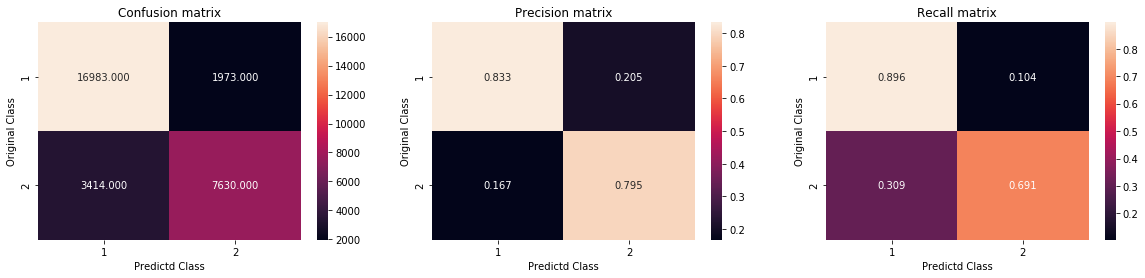

In [84]:
predicted_y=np.array(predict_y>0.5,dtype=int)
#y_pred is the probability we have. We are applying a boolean condition 
#i.e if we have probably more than 0.5, it's a positive(True or 1) and less than 0.5 is Negative(False or 0).
#so we will get an array that contains True/False
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test,predicted_y)

# Xgboost with Hypaeparameter Tuning

In [85]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

#train = pd.read_csv('train_modified.csv')
target = 'is_duplicate'

In [86]:
# lets define a function which will helpus create XGboost model and perform cross-validation
def XGboost_model(alg,Xtrain,useTrainCV=True,cv_folds=5,early_stopping_rounds=50):
    if useTrainCV:
        xgb_params=alg.get_xgb_params()
        xgtrain=xgb.DMatrix(Xtrain,label=y_train)
        cvresult=xgb.cv(xgb_params,xgtrain,num_boost_round=alg.get_params()['n_estimators'],nfold=cv_folds,
                        metrics='auc',early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    #Fit the algorithm on data
    alg.fit(Xtrain,y_train,eval_metric='auc')
    
    #predict training set
    dtrain_predictions=alg.predict(Xtrain)
    dtrain_pred_proba=alg.predict_proba(Xtrain)[:,1]
    
    #PRintmodel report:
    print('Model report')
    print("Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_pred_proba))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    
    feat_imp.plot(kind='bar',title='Feature Importance')
    plt.ylabel('Feature Importance Score')

Model report
Accuracy : 0.9266
AUC Score (Train): 0.980328


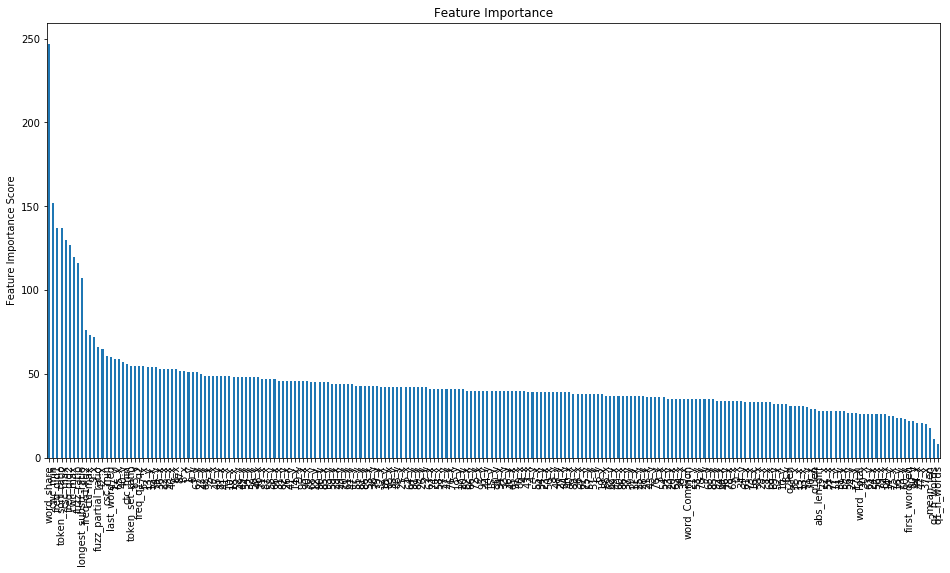

In [87]:
#Fix learning rate and number of estimators for tuning tree-based parameters
predictors = [x for x in X_train.columns if x not in [target]]
#predictors
xgb1=XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,
                  colsample_bytree=0.8,objective='binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
XGboost_model(xgb1,X_train)